## Эксперименты с графами

In [1]:
import igraph as ig
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

### Для начала посмотрим, что умеет делать библиотека igraph

#### Можно создавать графы ручками

In [2]:
g = ig.Graph()
g.add_vertices(7)
g.add_edges([(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)]) # первое сообщество
g.add_edges([(4, 5), (5, 6), (6, 4)]) # второе сообщество
g.add_edges([(0, 4)])

In [3]:
print g

IGRAPH U--- 7 9 --
+ edges:
0--1 0--2 0--3 1--2 2--3 4--5 5--6 4--6 0--4


### Существуют разные варианты визуализации графов

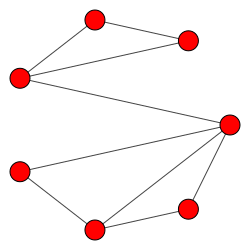

In [4]:
ig.plot(g, layout=g.layout_circle(), bbox=(250, 250))

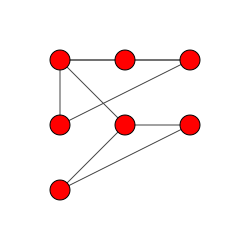

In [5]:
ig.plot(g, layout=g.layout_grid(), bbox=(250, 250), margin=60) # отступ от границ рисунка

### Также есть очень удобный класс, в котором каждой вершине сопоставлено сообщество

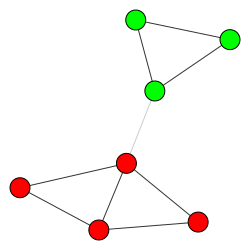

In [6]:
clustering = ig.VertexClustering(g, membership=[0,0,0,0,1,1,1])
ig.plot(clustering, bbox=(250, 250))

### Существуют возможность генерировать стандартные графы

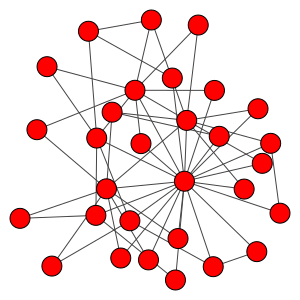

In [7]:
g = ig.Graph.Barabasi(30, 2)
ig.plot(g, bbox=(300, 300))

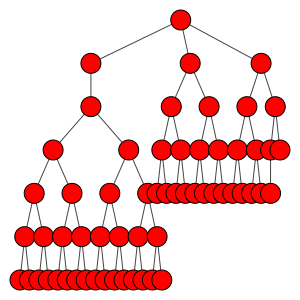

In [8]:
g = ig.Graph.Tree(60, 2)
ig.plot(g, bbox=(300, 300), layout=g.layout_reingold_tilford())

# Испытания методов

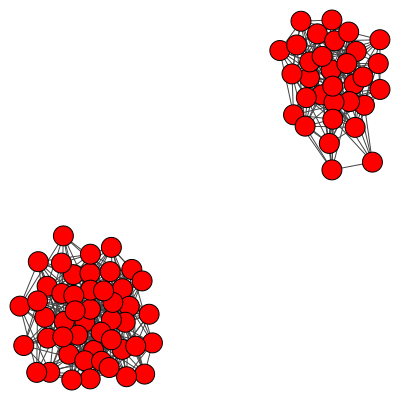

In [9]:
g1 = ig.Graph.Erdos_Renyi(n=32, p=0.4) # случайный граф Эрдёша-Реньи с вероятностью появления ребра 0.4
g2 = ig.Graph.Erdos_Renyi(n=48, p=0.3)
g3 = g1.disjoint_union(g2) # объединяем два графа (пока без ребер)
ig.plot(g3, bbox=(400, 400))

## Модельные данные

### Planted l-partition model генерирует граф из $n = g * l$ вершин c $l$ сообществами по $g$ вершин в каждом. Вероятность того, что две вершины из одной группы будут соединены друг с другом $p_{in}$. Если вершины из разных групп $-$ $p_{out}$.

In [10]:
def lpartition(communities, vertices_in_community, prob_in, prob_out):
    G = ig.Graph()
    for i in range(communities):
        G = G.disjoint_union(ig.Graph.Erdos_Renyi(vertices_in_community, prob_in))
    
    # теперь нужно соединить с вероятностью prob_out вершины из разных сообществ
    for vert1 in G.vs.indices:
        for vert2 in G.vs.indices:
            if vert1 / vertices_in_community != vert2 / vertices_in_community and not G.are_connected(vert1, vert2):
                # неравенство здесь означает, что вершина 1 и вершина 2 принадлежат разным сообществам
                if np.random.rand() < prob_out:
                    G.add_edge(vert1, vert2)
    
    # для каждой вершины нужно указать, к какому именно кластеру она относится
    membership = []
    for i in range(communities):
        membership.extend([i] * vertices_in_community)
    return ig.VertexClustering(G, membership)

### Пример

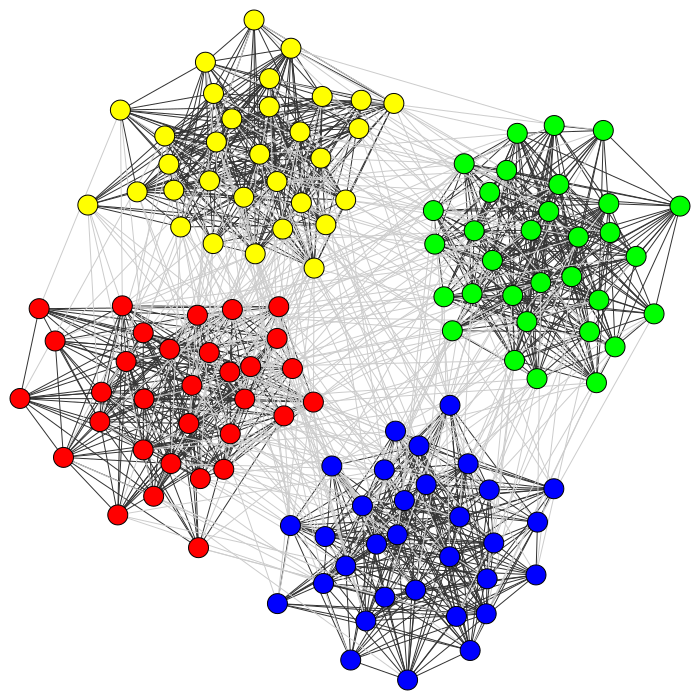

In [11]:
G = lpartition(4, 32, 0.5, 0.025)
ig.plot(G, bbox=(700, 700))

### Также нам потребуется генератор, посредством которого будет постепенно зашумляться граф (то есть будут добавляться ребра, соединяющие вершины из разных сообществ)

In [12]:
def adding_noise(GVC, step, count):
    
    yield GVC
    edges = []

    for vert in GVC.graph.vs:
        for current in range(vert.index, len(GVC.graph.vs)):
            if GVC.membership[vert.index] != GVC.membership[current] and not GVC.graph.are_connected(vert.index, current):
                edges.append((vert.index, current))
                # создаем список ребер, затем перемешиваем его
    np.random.shuffle(edges)
    dist = int(len(edges) * step)

    # постепенно зашумляем
    for i in range(count):
        GVC.graph.add_edges(edges[i*dist:(i+1)*dist])
        yield GVC

##### Примечание: метод edge_betweenness имеет колоссальную сложность, поэтому я не стал рассматривать его

In [13]:
step = 0.02
count = 20
num_of_methods = 6
iterations = 15 # усреднение

nmi_results = np.zeros((num_of_methods, count+1))
sjd_results = np.zeros((num_of_methods, count+1))

start = time.time()
for i in range(iterations):
    current_nmi = np.zeros((num_of_methods, count+1))
    current_sjd = np.zeros((num_of_methods, count+1))

    G_initial = lpartition(4, 64, 0.5, step)
    generator = adding_noise(G_initial, step, count)
    counter = 0
    
    for G in generator:
        G_not_labeled = G.graph
        G_test_list = []
        
        G_test_list.append(G_not_labeled.community_fastgreedy().as_clustering())
        G_test_list.append(G_not_labeled.community_walktrap().as_clustering())
        G_test_list.append(G_not_labeled.community_label_propagation())
        G_test_list.append(G_not_labeled.community_infomap())
        #G_test_list.append(G_not_labeled.community_edge_betweenness().as_clustering())
        G_test_list.append(G_not_labeled.community_multilevel())
        G_test_list.append(G_not_labeled.community_leading_eigenvector())
        
        for j in range(len(G_test_list)):
            current_nmi[j, counter] = 1.0 - ig.compare_communities(G, G_test_list[j], method='nmi')
            current_sjd[j, counter] = ig.compare_communities(G, G_test_list[j], method='sjd')
        
        counter += 1
        
    nmi_results += current_nmi
    sjd_results += current_sjd
    print 'Iteration', i+1, 'finished'

nmi_results /= iterations
sjd_results /= iterations

print 'worked', round(time.time() - start), 'seconds'

Iteration 1 finished
Iteration 2 finished
Iteration 3 finished
Iteration 4 finished
Iteration 5 finished
Iteration 6 finished
Iteration 7 finished
Iteration 8 finished
Iteration 9 finished
Iteration 10 finished
Iteration 11 finished
Iteration 12 finished
Iteration 13 finished
Iteration 14 finished
Iteration 15 finished
worked 76.0 seconds


### Взглянем на результаты

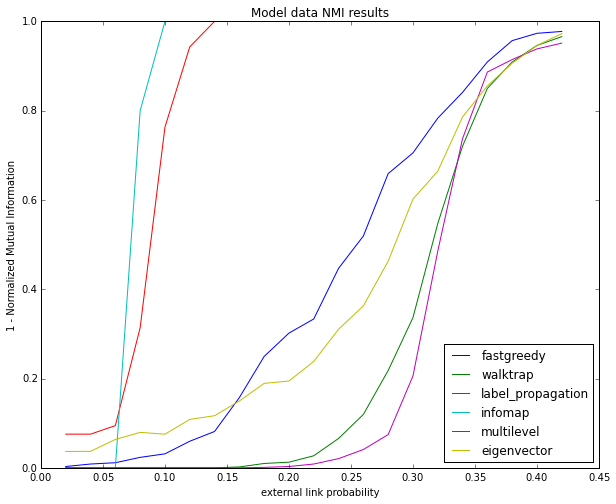

In [14]:
pp = PdfPages('model_data_nmi.pdf')

plt.figure(figsize=(10, 8))
probs_out = np.arange(step, (count+2)*step, step)
for i in range(num_of_methods):
    plt.plot(probs_out, nmi_results[i])
    
plt.legend(['fastgreedy', 'walktrap', 'label_propagation', 'infomap', 'multilevel', 'eigenvector'], loc='lower right')
plt.xlabel('external link probability')
plt.ylabel('1 - Normalized Mutual Information')
plt.title('Model data NMI results')

pp.savefig()
pp.close()

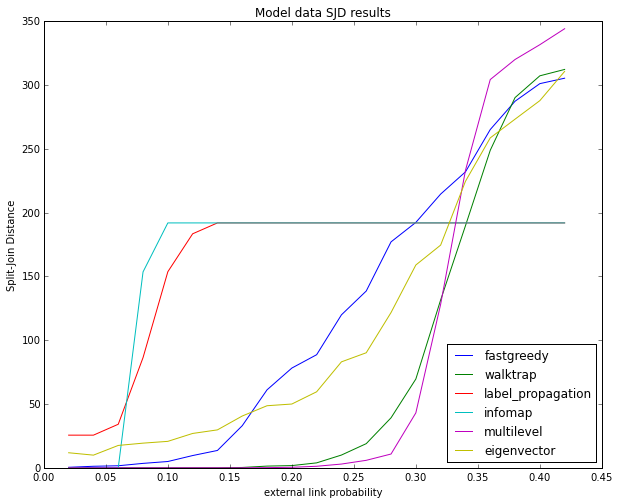

In [15]:
pp = PdfPages('model_data_sjd.pdf')

plt.figure(figsize=(10, 8))
probs_out = np.arange(step, (count+2)*step, step)
for i in range(num_of_methods):
    plt.plot(probs_out, sjd_results[i])
    
plt.legend(['fastgreedy', 'walktrap', 'label_propagation', 'infomap', 'multilevel', 'eigenvector'], loc='lower right')
plt.xlabel('external link probability')
plt.ylabel('Split-Join Distance')
plt.title('Model data SJD results')

pp.savefig()
pp.close()

## Learning Social Circles in Networks

In [16]:
import pandas as pd

#### Создателей igraph следовало бы выпороть за то, что они разрешают такое

In [3]:
G = ig.Graph()
G.add_vertices([5, 5, 5, 'abc', 'def', 'abc'])

In [4]:
print G.vs.indices
print G.vs['name']

[0, 1, 2, 3, 4, 5]
[5, 5, 5, 'abc', 'def', 'abc']


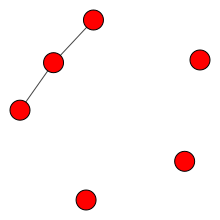

In [5]:
G.add_edges([('abc', 'def'), ('abc', 5)])
ig.plot(G, bbox=(220, 220))

### Заготовки

In [17]:
def read_nodeadjlist(filename):
    G = ig.Graph()
    G.vs['name'] = []
    for line in open(filename):
        e1, es = line.split(':')
        if e1 not in G.vs['name']:
            G.add_vertex(e1)
        es = es.split()
        for e in es:
            if e == e1: continue
            if not e in G.vs['name']:
                G.add_vertex(e)
            G.add_edge(e1, e)
    return G

### Собственно, весь подсчет

In [ ]:
default_folder = './Social Circles/'
egonetFolderName = default_folder + 'egonets/'
submission = pd.read_csv(default_folder + 'sample_submission.csv')

flag = False

while(not flag):
    modularity_fastgreedy = []
    modularity_walktrap = []
    modularity_label_propagation = []
    modularity_infomap = []
    modularity_multilevel = []
    modularity_eigenvector = []

    modularities = [modularity_fastgreedy, modularity_walktrap, modularity_label_propagation, 
                    modularity_infomap, modularity_multilevel, modularity_eigenvector]
    
    try:
        # Sometimes leading eigenvector method reaches maximum number of iterations
        # We will ignore it
        for userId in list(submission['UserId']):
            if userId == 26019:
                continue # bad user
            filename = str(userId) + '.egonet'
            G = read_nodeadjlist(egonetFolderName + filename) # строим граф

            # результаты базовых методов

            fastgreedy = G.copy().simplify().community_fastgreedy().as_clustering()
            modularity_fastgreedy.append(fastgreedy.modularity)

            walktrap = G.community_walktrap().as_clustering()
            modularity_walktrap.append(walktrap.modularity)

            label_propagation = G.community_label_propagation()
            modularity_label_propagation.append(label_propagation.modularity)

            infomap = G.community_infomap()
            modularity_infomap.append(infomap.modularity)

            multilevel = G.community_multilevel()
            modularity_multilevel.append(multilevel.modularity)

            leading_eigenvector = G.community_leading_eigenvector()
            modularity_eigenvector.append(leading_eigenvector.modularity)

            print 'Processing user', userId, 'finished'
        print 'Done'
    except:
        print 'Leading eigenvector maximum number of iterations reached'
        continue
        
    flag = True

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


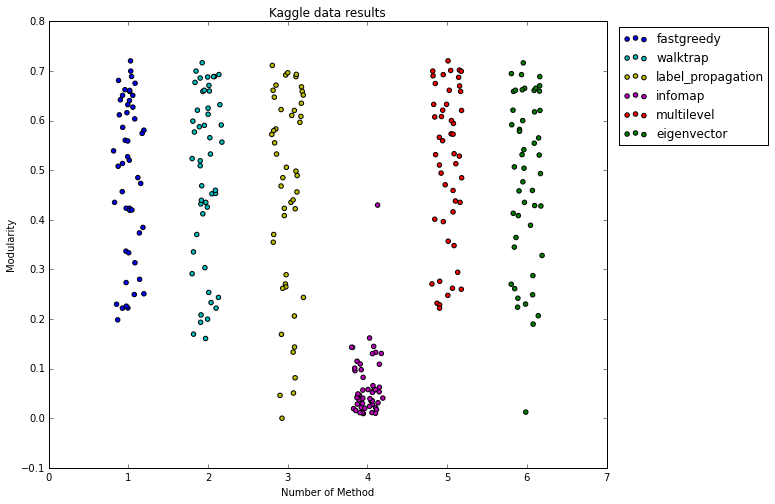

In [20]:
pp = PdfPages('kaggle_modularity.pdf')

plt.figure(figsize=(10, 8))
methods = ['fastgreedy', 'walktrap', 'label_propagation', 'infomap', 'multilevel', 'eigenvector']
colors = ['b', 'c', 'y', 'm', 'r', 'g']

for i in range(len(modularities)):
    x_axis = 0.4*np.random.rand(len(modularities[i])) - 0.2 + i + 1
    y_axis = np.array(modularities[i])
    plt.scatter(x_axis, y_axis, c=colors[i]*len(modularities[i]), label=methods[i])

plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.ylabel('Modularity')
plt.xlabel('Number of Method')
plt.title('Kaggle data results')

pp.savefig(bbox_inches='tight')
pp.close()